# Sistem Rekomendasi Jurnal

In [3]:
import tkinter as tk
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import statistics as stats

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Text Preprocessing
*Text preprocessing* atau prapemrosesan teks adalah serangkaian teknik yang digunakan untuk mempersiapkan dokumen teks untuk diproses oleh mesin pencari yang melibatkan beberapa tahap seperti:
- *Casefolding*
- *Special characters removal* (*Cleaning*)
- *Tokenization*
- *Stopwords removal*
- *Stemming*

In [4]:
# Hilangkan simbol dan tanda baca
def remove_punctuation(text):
    # remove punctuation using string library
    text = "".join([char for char in text if char not in string.punctuation])
    # remove certain characters
    text = re.sub(r'\s+', ' ', text)
    return text

# Prapemrosesan
def preprocess_text(text, lang):
    # Cleaning & Casefolding
    text = remove_punctuation(text.lower())

    # Tokenization
    words = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words(lang)) # => ("is", "that", "at", ...)
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return words


Berikut merupakan contoh hasil dari tahapan text preprocessing yang dilakukan:

In [10]:
text = "This is an examples of text preprocessing using NLTK. It includes casefolding, tokenization, stopword removal, and stemming."
preprocessed_text = preprocess_text(text, 'english')
print(preprocessed_text)

['exampl', 'text', 'preprocess', 'use', 'nltk', 'includ', 'casefold', 'token', 'stopword', 'remov', 'stem']


## Feature Extraction
Ekstraksi fitur dilakukan dengan menerapkan tahap prapemrosesan kata pada data teks judul dan abstrak masing-masing dokumen yang terdapat dalam dataset, lalu menghitung vektor bobot TF-IDF untuk setiap data teks yang sudah terproses.

In [11]:
# Ambil data dari file .csv
journalDtf = pd.read_csv("Datasets/data copy.csv")
journalDtf = journalDtf.drop('no', axis=1)
journalDtf['combined'] = journalDtf['judul'] + " " + journalDtf['abstrak']

features = []

# Melakukan text preprocessing pada setiap teks dokumen
for i in range(len(journalDtf)):
    features.append(preprocess_text(journalDtf.loc[i, 'combined'], journalDtf.loc[i, 'lang']))

# Menghitung vector bobot TF-IDF masing-masing fitur 
vectorizer = TfidfVectorizer(analyzer=lambda x: x)
tfidfMatrix = vectorizer.fit_transform(features)

# Print contoh hasil preprocessing kata
print("Hasil prapemrosesan teks:")

for i in range(5):
    print(features[i])

# Print vektor tfidf dari dataset
print("\nHasil perhitungan vektor bobot TF-IDF:")
print(tfidfMatrix.toarray()[:5])

Hasil prapemrosesan teks:
['dynam', 'studi', 'export', 'china', 'south', 'korea', 'econom', 'growth', 'china', 'paper', 'appli', 'annual', 'data', '1998', '2016', 'search', 'dynam', 'oper', 'mechan', 'export', 'china', 'south', 'korea', 'econom', 'growth', 'china', 'vector', 'error', 'correct', 'model', 'util', 'conduct', 'empir', 'analysi', 'result', 'indic', 'longrun', 'relationship', 'specif', 'export', 'china', 'south', 'korea', 'increas', '1', 'per', 'cent', 'econom', 'growth', 'china', 'increas', '0769', 'per', 'cent', 'meanwhil', 'result', 'granger', 'causal', 'test', 'also', 'reveal', 'unidirect', 'causal', 'exist', '5', 'per', 'cent', 'signific', 'level', 'importantli', 'result', 'vector', 'error', 'correct', 'mechan', 'show', 'econom', 'growth', 'deriv', 'longrun', 'equilibrium', 'short', 'run', 'return', 'longrun', 'equilibrium', '22', 'percent']
['panel', 'approach', 'govern', 'expenditur', 'influenc', 'human', 'develop', 'index', 'studi', 'investig', 'influenc', 'govern', 

## Pencarian Query dan Perbandingan Cosine Similarity
Pencarian dan perangkingan hasil pencarian query dilakukan dengan menghitung vektor bobot TF-IDF dan membandingkan seberapa dekat sudut vektor bobot query dengan vektor bobot lainnya yang ada pada dokumen dalam dataset. 

Perhitungan sudut ini dapat dilakukan dengan menghitung nilai $cos(\theta)$ dari sudut antar vektor query dan vektor dokumen dengan formula berikut:

$$cos(\theta) = \frac{\vec{Q} \cdot \vec{D}}{|\vec{Q}||\vec{D}|}$$

Hasil perhitungan kemudian akan digunakan sebagai acuan untuk mengurutkan hasil pencarian dokumen.

In [13]:
def getSearchQueryRangking(query):
    queryTfIdf = vectorizer.transform([preprocess_text(query, 'english')])
    cosine_sim = cosine_similarity(queryTfIdf, tfidfMatrix)

    return cosine_sim.argsort()[0][::-1]

Implementasi UI sederhana untuk sistem pencarian:

Pencarian dilakukan dengna memasukan sebuah query kedalam kolom teks query lalu menekan tombol search, sistem kemudian akan manampilkan 10 judul jurnal dengan nilai kemiripan tertinggi dengan query yang dimasukkan.

In [16]:
def showSearchResults():
    output_area.delete("1.0", "end")
    
    query = input_field.get("1.0", tk.END).strip()
    rangkingIndex = getSearchQueryRangking(query)

    for i in range(10):
        output_area.insert(tk.END, journalDtf.loc[rangkingIndex[i], 'judul'] + "\n\n")

window = tk.Tk()

input_field = tk.Text(window, height=1)
input_field.pack()

search_button = tk.Button(window, text="Search", command=showSearchResults)
search_button.pack()

output_area = tk.Text(window)
output_area.pack()

window.mainloop()

## Evaluasi
Evaluasi dilakukan dengan menghitung nilai *precision*, *recall*, *F-score*, dan MAP (*Mean Average Precision*) dari hasil pencarian sistem.

MAP      :  0.5162037037037037
Precision:  0.45454545454545453
Recall   :  0.7142857142857143
F1       :  0.5555555555555556
[[6, 14], [1, 0]]


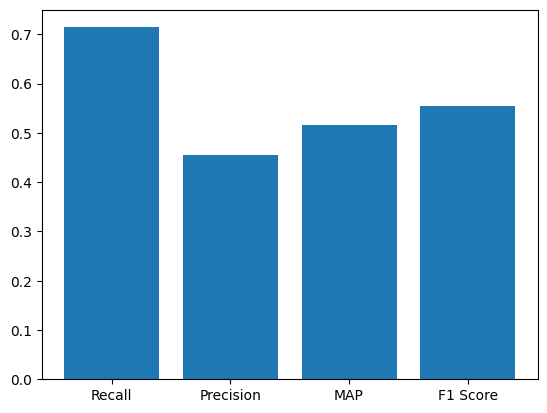

In [17]:
query = "Education"
relevantIndexes = [4, 5, 11, 12, 18, 19, 20]

rangkingIndex = getSearchQueryRangking(query)
searchResults = 10

confMatrix = [[0, 0], [0, 0]]
precision = 0
recall = 0
MAPval = 0 # Mean Average Precision
F1score = 0 # 2*Precision*Recall/(Precision + Recall)

# Menghitung nilai precision, recall, fscore, MAP, dll
for i in  range(len(rangkingIndex)):
    if rangkingIndex[i] in relevantIndexes:
        confMatrix[0][0] += 1
        MAPval += confMatrix[0][0]/(confMatrix[0][0] + confMatrix[0][1])
    else:
        confMatrix[0][1] += 1
    
    confMatrix[1][0] = len(relevantIndexes) - confMatrix[0][0]
    confMatrix[1][1] = len(rangkingIndex) - i - 1

    if i == searchResults:
        precision = confMatrix[0][0] / (confMatrix[0][0] + confMatrix[0][1])
        recall = confMatrix[0][0] / (confMatrix[0][0] + confMatrix[1][0])

MAPval /= confMatrix[0][0]
F1score = stats.harmonic_mean([precision, recall])

print("MAP      : ", MAPval)
print("Precision: ", precision)
print("Recall   : ", recall)
print("F1       : ", F1score)
print(confMatrix)

# Buat diagram
y = [recall, precision, MAPval, F1score]
labels = ['Recall', 'Precision', 'MAP', 'F1 Score']
plt.bar(labels, y)
plt.show()